# Spotify's Top 100 Songs of 2017

## Exploring the data

Let's start by loading the dataset and taking a look at some quick relationships of the different variables present. What's interesting about this dataset is that it does not include information for any song that was not in the top 100 streamed songs for the year. Effectively, this dataset provides a look at what makes the top songs tick, so we can assume that non-top performing songs have the inverse of all the present variables.

For this analysis we can look for the features that will help predict the 'valence' of a given song. The valence is the measure of how positive or negative a track is.

#### List of Created Features
duration_sec, log_speechiness, log_tempo, name_length,
is_danceable, positive_songs, neg_song_tempo

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

In [90]:
df = pd.read_csv('featuresdf.csv')

In [113]:
#creating name_length to see if that is related to the other variables
df['name_length'] = df['name'].str.len()

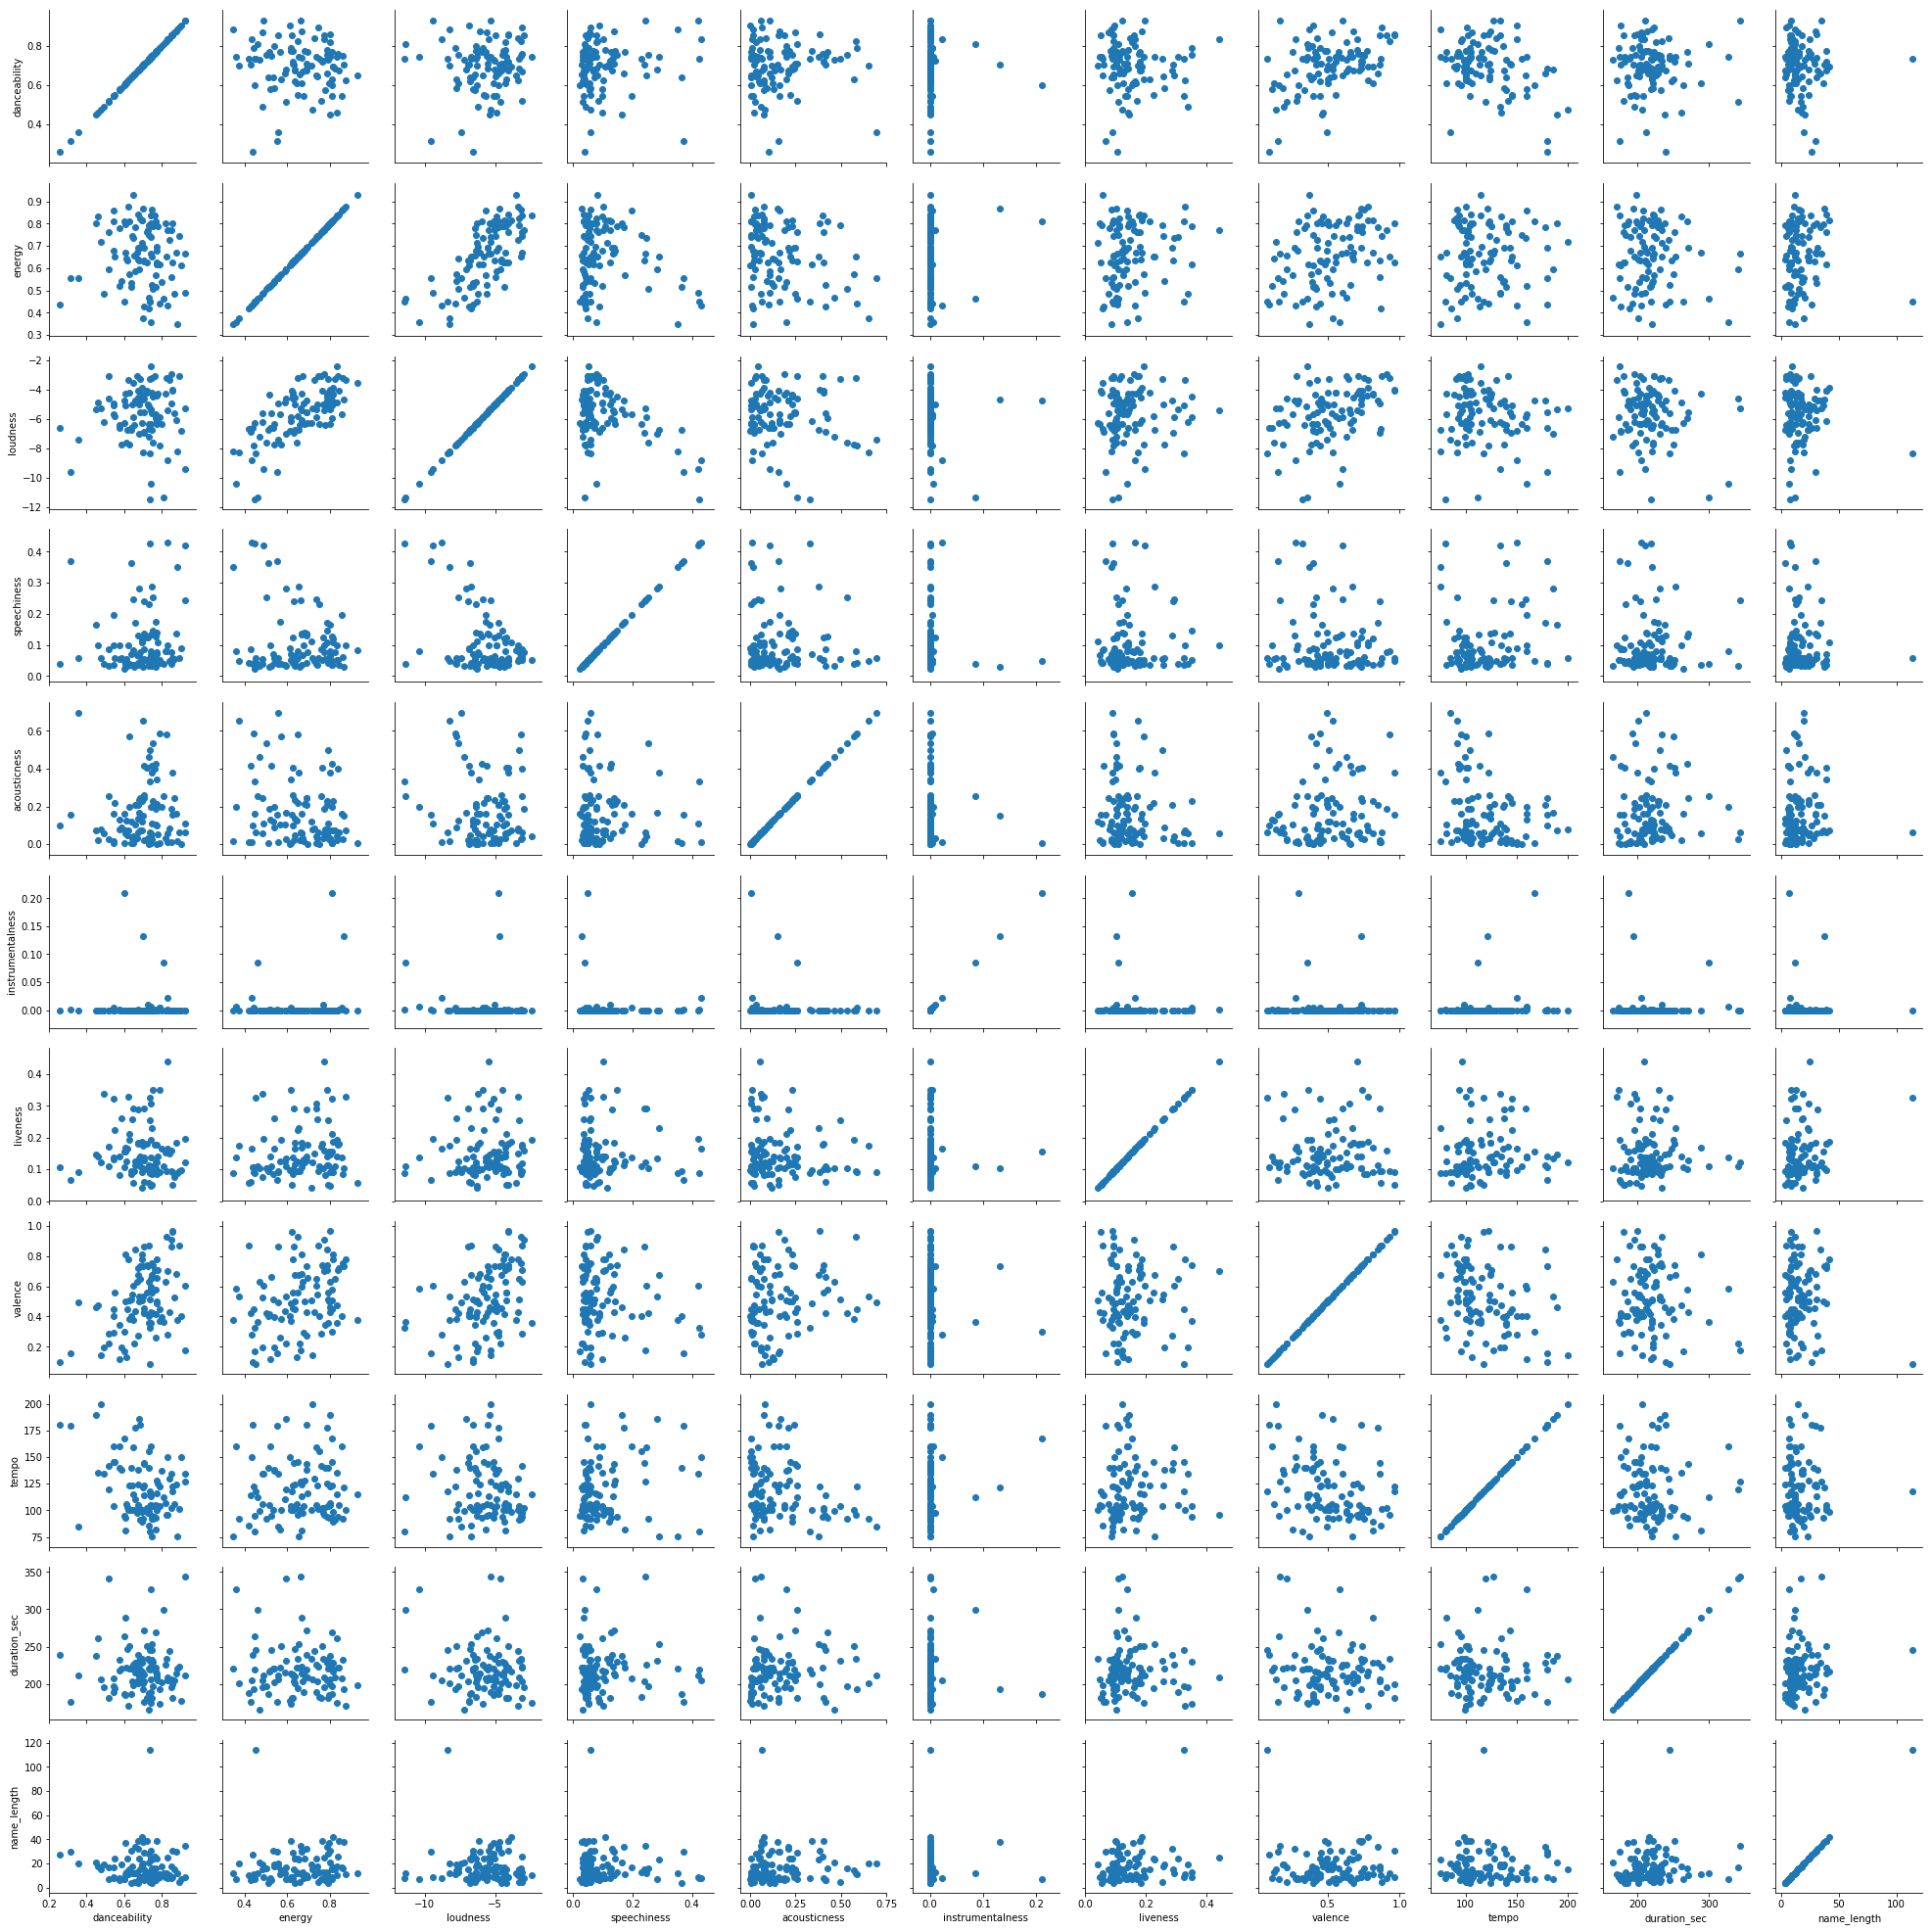

In [112]:
#converting variable of milliseconds to seconds for ease of viewing
df['duration_sec'] = df['duration_ms'] / 1000

#selecting continuous variables and removing variable with abnormally long name
g = sns.PairGrid(df.loc[:, ['danceability', 
                            'energy', 
                            'loudness', 
                            'speechiness', 
                            'acousticness', 
                            'instrumentalness', 
                            'liveness', 
                            'valence', 
                            'tempo', 
                            'duration_sec',
                            'name_length']])
g.map(plt.scatter)
plt.show()

### Scatter Plot Grid

There are too many continuous variables in the matrix to make this a clear figure, but it does show some interesting trends in the data. For instance, it looks like "instrumentalness" is non-normally distributed, due to the high amount of songs that do not rank high in that variable. Also, there could be some redundant information if this dataset is used to highlight common characteristics of top rated songs. Let's look at a heatmap of the correlation matrix to get a better view of this.

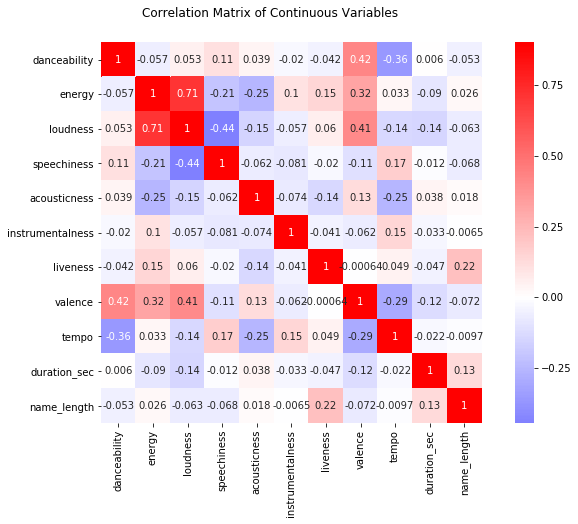

In [121]:
#filtering to just the continuous variables in the dataset
df_continuous = df.loc[:, ['danceability', 
                  'energy', 
                  'loudness', 
                  'speechiness', 
                  'acousticness', 
                  'instrumentalness', 
                  'liveness', 
                  'valence', 
                  'tempo', 
                  'duration_sec', 
                  'name_length']]

#filtering to the categorical variables in the dataset
df_categorical = df.loc[:, ['name', 
                            'artist', 
                            'key', 
                            'mode', 
                            'time_signature']]

#heatmap to show correlation coefficients between all the variables
plt.figure(figsize=(12,7))
hmap = sns.heatmap(df_continuous.corr(), 
                   annot=True, 
                   square=True, 
                   center=0, 
                   vmax=0.9, 
                   cmap='bwr')
plt.suptitle('Correlation Matrix of Continuous Variables', y=0.95)
plt.show()

### Corrmat Heatmap

The correlations confirm what was mentioned above. Speechiness and loudness are negatively correlated which makes sense. It also looks like valence correlates decently with danceability, energy, and loudness. Tempo and danceability are negatively correlated, which at first glance seems counter intuitive, but makes sense considering a high tempo would be difficult to dance to. The highest correlation is between loudness and energy with a 0.71.

Before continuing to feature engineering, let's check for normality and edit variables so that they can be treated as normal for future modeling purposes.

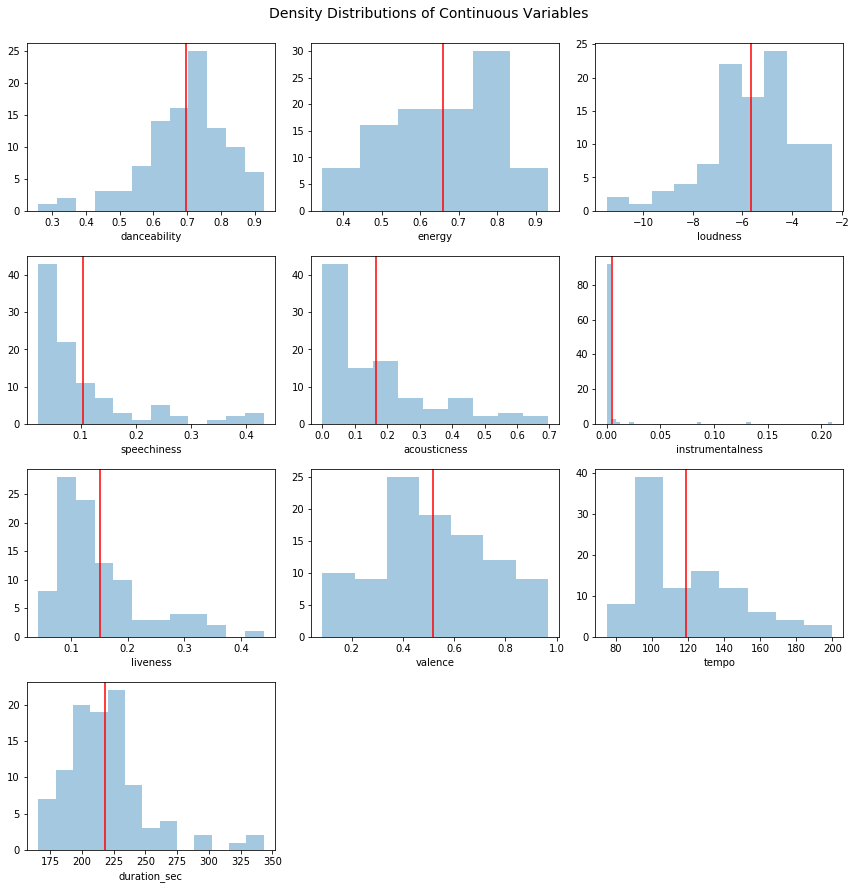

In [55]:
plt.figure(figsize=(12,12))

n = 0
for i in df_continuous.columns:
    n += 1
    plt.subplot(4,3,n)
    sns.distplot(df_continuous[i].dropna(), kde=False)
    plt.axvline(df_continuous[i].mean(), color='red')
    
plt.suptitle('Density Distributions of Continuous Variables', y=1.025, fontsize=14)
plt.tight_layout()
plt.show()

### Histogram Matrix

Checking for normality shows that there are a few variables that aren't normally distributed. Speechiness, Acousticness, Liveness, and Tempo all seem to be log-normally distributed. Instrumentalness contains so many 0 values and there are so few datapoints on the higher end that it is almost categorical for these songs. All of the top 100 songs are not very instrumental and therefore it doesn't help much without including data from non-top 100 songs. We could say that if there is a song that scores high on the instrumental variable then it is unlikely to be in the top 100. This variable could be pretty impactful when looking at feature classification and top 100 prediction. Let's take the log of the four variables above and re-check the distributions.

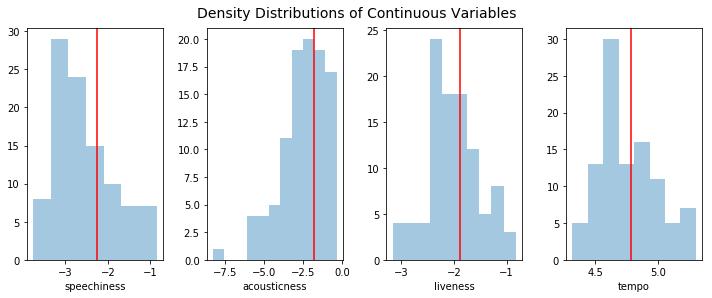

In [89]:
plt.figure(figsize=(10,4))

log_variables = ['speechiness', 
                 'acousticness', 
                 'liveness',
                 'tempo'
                ]
n = 0
for i in log_variables:
    n += 1
    plt.subplot(1,4,n)
    sns.distplot(np.log(df_continuous[i].dropna()), kde=False)
    plt.axvline(np.log(df_continuous[i].mean()), color='red')
    
plt.suptitle('Density Distributions of Continuous Variables', 
             y=1.025, fontsize=14)
plt.tight_layout()
plt.show()

### Log Variables

It looks like taking the log of the four variables did a decent job of normalizing the data. The last thing we want to do is create some boxplots for the continuous variables so that we can check for any outliers that could be present. From there, let's create these four new variables as log_name and add them to a new dataframe that will store the features we generate for future modeling efforts.

## Feature Engineering

In the next section we're going to take what we learned while exploring the data and generate a few features for future modeling efforts. First we will normalize our log-normal distributed variables so that they are on similar scales. After that we can start generating  continuous variables from our categorical ones and select what features we will use for the future Least Squares Regression model.

   valence  danceability  energy  loudness  mode    tempo  log_tempo
0    0.931         0.825   0.652    -3.183   0.0   95.977   4.564109
1    0.813         0.694   0.815    -4.328   1.0   88.931   4.487861
2    0.846         0.660   0.786    -4.757   1.0  177.833   5.180845
3    0.446         0.617   0.635    -6.769   0.0  103.019   4.634913
4    0.811         0.609   0.668    -4.284   1.0   80.924   4.393510


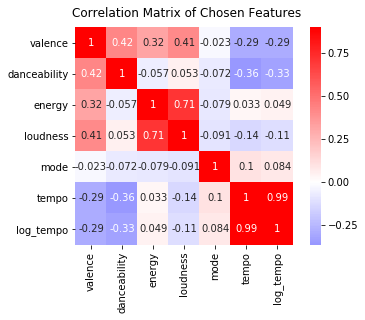

In [132]:
#pulling the 4 variables from the original dataset that correlated
#best with valence and mode to help classify the valence
df_features = df.loc[:, ['valence', 
                        'danceability',
                        'energy',
                        'loudness',  
                        'mode', 
                        'tempo']
                    ]

#adding the log corrected tempo as it is correlatable with valence
df_features['log_tempo'] = np.log(df_continuous['tempo'].dropna())

print(df_features.head(5))
hmap2 = sns.heatmap(df_features.corr(), 
                   annot=True, 
                   square=True, 
                   center=0,
                   vmax=0.9,  
                   cmap='bwr')
plt.suptitle('Correlation Matrix of Chosen Features', y=0.95)
plt.show()

In [217]:
#lets make danceability and valence a categorical variable

df_features['is_danceable'] = np.where(df_features['danceability'] >= 0.55, 1, 0)
df_features['negative_songs'] = np.where(df_features['valence'] <= 0.5, 1, 0)
df_features.groupby('negative_songs').describe()


danceability                                                   \
                      count      mean       std    min    25%    50%     75%   
negative_songs                                                                 
0                      51.0  0.735608  0.082246  0.548  0.682  0.734  0.7725   
1                      49.0  0.656449  0.148186  0.258  0.573  0.675  0.7680   

                      energy            ...       tempo          valence  \
                  max  count      mean  ...         75%      max   count   
negative_songs                          ...                                
0               0.927   51.0  0.695039  ...    123.0725  186.054    51.0   
1               0.927   49.0  0.624939  ...    141.9710  199.864    49.0   

                                                                        
                    mean       std     min    25%    50%    75%    max  
negative_songs                                                          
0               0.689569  0.130572  0.5010  0.583  0.678  0.779  0.966  
1               0.337488  0.119667  0.0862  0.260  0.374  0.427  0.498  

[2 rows x 80 columns]

### Importance of Valence

Interstingly enough, the average danceability of a track is higher when there is a positive valence to a song. Valence has a correlation with danceability which could indicate that people find positive songs easier to dance too. This does make sense considering valence is a perceived value from how a song sounds and does not necessarily take the lyrics into consideration (i.e. a song with depressing lyrics could still have a positive sound and vice versa).

Now we can look at some relationships of variables to determine how they correlate to danceabilty or valence.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


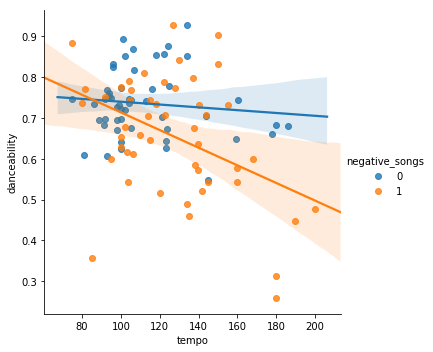

In [218]:
#tempo and loudness are both physical measures of the songs and not a
#generated variables based on other factors\
sns.lmplot(
        x="tempo", 
        y="danceability", 
        hue="negative_songs", 
        data=df_features, 
        scatter=True
)
plt.show()



### Danceability and Tempo

There is a trend in the data where positive songs have a relatively flat danceability score as tempo increases, but more negative songs have a lower danceability score as the tempo increases. To help predict danceability, we can use the positivity classification and tempo to help determine if a song is more danceable or not. This could also be an interesting feature with regards to genre evaluation in the top 100 songs. 

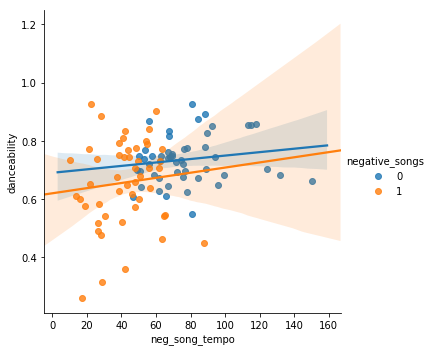

In [220]:
df_features['neg_song_tempo'] = df_features['tempo'] * df_features['valence']

sns.lmplot(
        x="neg_song_tempo", 
        y="danceability",  
        data=df_features, 
        hue="negative_songs", 
        scatter=True
)
plt.show()

In [209]:
#converting loudness to be positive for filtering and PCA compatability
df_features['loudness'] = df_features['loudness'].abs()

In [211]:
df_features.head(5)

,valence,danceability,energy,loudness,mode,tempo,log_tempo,is_danceable,positive_songs,negative_songs,neg_song_tempo
0,0.931,0.825,0.652,3.183,0.0,95.977,4.564109,1,1,0,0.000
1,0.813,0.694,0.815,4.328,1.0,88.931,4.487861,1,1,0,0.000
2,0.846,0.660,0.786,4.757,1.0,177.833,5.180845,1,1,0,0.000
3,0.446,0.617,0.635,6.769,0.0,103.019,4.634913,1,0,1,103.019
4,0.811,0.609,0.668,4.284,1.0,80.924,4.393510,1,1,0,0.000


In [212]:
df_pca = df_features.loc[:, ['danceability', 
                             'energy', 
                             'loudness', 
                             'log_tempo', 
                             'neg_song_tempo']
]

X = StandardScaler().fit_transform(df_pca)

Xt = X.T
Cx = np.cov(Xt)
print(' Covariance Matrix:\n{}\n'.format(Cx))

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 5).T
    print('Eigenvector {}:\n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}:\n{}'.format(i + 1, eig_val_cov[i]))
    print(25 * '_')

 Covariance Matrix:
[[ 1.01010101 -0.05781758 -0.05329159 -0.3326397  -0.41263211]
 [-0.05781758  1.01010101 -0.71630445  0.04927182 -0.17587189]
 [-0.05329159 -0.71630445  1.01010101  0.1137526   0.26911837]
 [-0.3326397   0.04927182  0.1137526   1.01010101  0.46591397]
 [-0.41263211 -0.17587189  0.26911837  0.46591397  1.01010101]]

Eigenvector 1:
[[-0.35741383]
 [-0.40997163]
 [ 0.50042495]
 [ 0.40406529]
 [ 0.53896635]]
Eigenvalue 1:
2.0166872717274824
_________________________
Eigenvector 2:
[[ 0.44431088]
 [-0.57862861]
 [ 0.46842112]
 [-0.42323006]
 [-0.26312497]]
Eigenvalue 2:
1.5904355023588748
_________________________
Eigenvector 3:
[[ 0.75660512]
 [ 0.07394781]
 [-0.00103922]
 [ 0.64531413]
 [ 0.07515987]]
Eigenvalue 3:
0.6798222814015872
_________________________
Eigenvector 4:
[[-0.31412613]
 [-0.03797277]
 [ 0.22505363]
 [ 0.46563665]
 [-0.79524601]]
Eigenvalue 4:
0.48974686488698727
_________________________
Eigenvector 5:
[[-0.06096447]
 [-0.70014426]
 [-0.69246394]
 [

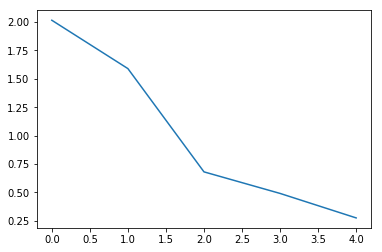

The percentage of total variance explained by each component.
 [0.39930408 0.31490623 0.13460481 0.09696988 0.054215  ]


In [213]:
plt.plot(eig_val_cov)
plt.show()

print(
    'The percentage of total variance explained by each component.\n', 
    eig_val_cov / sum(eig_val_cov)     
)

In [226]:
df_features.head()

,valence,danceability,energy,loudness,mode,tempo,log_tempo,is_danceable,positive_songs,negative_songs,neg_song_tempo
0,0.931,0.825,0.652,3.183,0.0,95.977,4.564109,1,1,0,89.354587
1,0.813,0.694,0.815,4.328,1.0,88.931,4.487861,1,1,0,72.300903
2,0.846,0.660,0.786,4.757,1.0,177.833,5.180845,1,1,0,150.446718
3,0.446,0.617,0.635,6.769,0.0,103.019,4.634913,1,0,1,45.946474
4,0.811,0.609,0.668,4.284,1.0,80.924,4.393510,1,1,0,65.629364


In [227]:
X = df_features.values
y = df_features.values[:, 9]

svc = SVC(kernel='linear')
rfe = RFE(estimator=svc, n_features_to_select=5)
rfe.fit(X, y)



RFE(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
  n_features_to_select=5, step=1, verbose=0)

In [210]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df_features.values[:,:]
Y = df_features.values[:,0]

test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, Y)

print(fit.scores_)

ValueError: Unknown label type: (array([0.931 , 0.813 , 0.846 , 0.446 , 0.811 , 0.4   , 0.515 , 0.733 ,
       0.86  , 0.0862, 0.401 , 0.219 , 0.498 , 0.777 , 0.281 , 0.504 ,
       0.782 , 0.471 , 0.742 , 0.708 , 0.294 , 0.298 , 0.494 , 0.966 ,
       0.426 , 0.42  , 0.781 , 0.195 , 0.661 , 0.457 , 0.579 , 0.535 ,
       0.632 , 0.511 , 0.656 , 0.386 , 0.364 , 0.119 , 0.527 , 0.557 ,
       0.168 , 0.718 , 0.872 , 0.557 , 0.737 , 0.672 , 0.326 , 0.907 ,
       0.175 , 0.418 , 0.36  , 0.605 , 0.142 , 0.544 , 0.371 , 0.647 ,
       0.733 , 0.863 , 0.587 , 0.632 , 0.402 , 0.732 , 0.682 , 0.462 ,
       0.595 , 0.485 , 0.159 , 0.868 , 0.754 , 0.26  , 0.222 , 0.43  ,
       0.394 , 0.13  , 0.506 , 0.286 , 0.534 , 0.374 , 0.497 , 0.356 ,
       0.558 , 0.71  , 0.678 , 0.603 , 0.704 , 0.419 , 0.196 , 0.501 ,
       0.343 , 0.448 , 0.45  , 0.962 , 0.427 , 0.649 , 0.376 , 0.272 ,
       0.403 , 0.631 , 0.434 , 0.0967]),)